In [1]:
"""Курсовой проект по численным методам
    Движение малого тела по орбите около двух массивных тел
    Поиск периода движения"""


In [ ]:
import math
import numpy as np
import scipy.linalg
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [17]:
#условия задачи

#точность
eps = 10**(-3)

#постоянные мю и мю с тильдой
mu = 1 / 82.45
mu_t = 1 - mu

#начальные условия - х, у и их производные(скорость по х и по у) в 0

x_0 = 1.8
y_0 = 0

x1_0 = 0
y1_0 = -1.04935751

U_0 = np.array([x_0, y_0, x1_0, y1_0])

#a - для решения - комплексная схема
a = complex(1/2, 1/2)

In [3]:
#функции r1 и r2 из системы уравнений
def r1(Y):
    return ((Y[0] + mu) ** 2 + Y[1] ** 2) ** 0.5
def r2(Y):
    return ((Y[0] - mu_t) ** 2 + Y[1] ** 2) ** 0.5

#вектор-функция правых частей 
def F(Y):
    return np.array([Y[2], Y[3], 2 * Y[3] + Y[0] - mu_t * (Y[0] + mu) / (r1(Y))**3 - mu * (Y[0] - mu_t) / (r2(Y))**3, -2 * Y[2] + Y[1] - mu_t * Y[1] / (r1(Y))**3 - mu * Y[1] / (r2(Y))**3])


#количество шагов
def count(T, h):
    return math.ceil(T/h)

#массив шагов
def steps(T, h):
    return np.arange(0, T + h, h)

#матрица Якоби для данной системы - с помощью численного дифференцирования
def yacobi(Y):
    tau = 10**(-2)
    matr = np.zeros((4, 4))
    matr[0][2] = 1 #(F(Y + np.array([0, 0, tau, 0])) - F(Y - np.array([0, 0, tau, 0])))[0] / (2 * tau)
    matr[1][3] = 1 #(F(Y + np.array([0, 0, 0, tau])) - F(Y - np.array([0, 0, 0, tau])))[1] / (2 * tau)
    matr[2][0] = (F(Y + np.array([tau, 0, 0, 0])) - F(Y - np.array([tau, 0, 0, 0])))[2] / (2 * tau) 
    matr[2][1] = (F(Y + np.array([0, tau, 0, 0])) - F(Y - np.array([0, tau, 0, 0])))[2] / (2 * tau)
    matr[2][3] = 2 #(F(Y + np.array([0, 0, 0, tau])) - F(Y - np.array([0, 0, 0, tau])))[2] / (2 * tau)
    matr[3][0] = (F(Y + np.array([tau, 0, 0, 0])) - F(Y - np.array([tau, 0, 0, 0])))[3] / (2 * tau)
    matr[3][1] = (F(Y + np.array([0, tau, 0, 0])) - F(Y - np.array([0, tau, 0, 0])))[3] / (2 * tau)
    matr[3][2] = -2 #(F(Y + np.array([0, 0, tau, 0])) - F(Y - np.array([0, 0, tau, 0])))[3] / (2 * tau)
    return matr

In [5]:
#одностадийная комплексная схема Розенброка
def cros1(T, h):
    N = count(T, h) + 1
    #массив решения
    solution = np.zeros((N, 4))
    solution[0] = U_0
    for i in range(N-1):
        w = np.linalg.solve(np.eye(4) - a * h * yacobi(solution[i]), F(solution[i]))
        solution[i+1] = solution[i] + h * w.real
    return solution

In [6]:
#правило Рунге
def runge(time, h, A, B):
    N = count(time, 2*h) + 1
    R = np.zeros(N)
    temp_h = A[:, 0]
    temp_2h = B[:, 0]
    for i in range(N):
        R[i] = abs(temp_h[2*i] - temp_2h[i]) / 3
    return R
    
#достижение заданной точности
def accuracy(time, h):
    R = max(runge(time, h))
    i = 0
    while R > eps:
        h1 = h/2
        R = max(runge(time, h1))
        i = i + 1
        print(i)
        h = h1
    return h

In [7]:
#проверка на наличие периодичности
def periodic(time, h, solution):
    #на вход подать матрицу с решением - координаты х и у
    #проход по матрице и поиск периода - когда х и у становятся равными стартовой точке - один оборот сделан
    #вопрос - как из этого выявлять период?
    N = count(time, h) + 1
    periodic = list()
    timer = steps(time, h)
    X = solution[:, 0]
    Y = solution[:, 1]
    summ = 0
    periodic.append(0)
    counter = 0
    for i in range(1, N-1):
        if x_0 - 0.1 <= X[i] and X[i] <= x_0 + 0.1 and y_0 - 0.01<= Y[i] and Y[i] < y_0 + 0.01 and timer[i] - periodic[counter] > 1:
            #periodic.add(int(timer[i]))
            counter += 1
            periodic.append(timer[i])
            print(i)
    
    #period = np.zeros(counter)
    #for j in range(len(periodic) - 1):
    #    period[j] = periodic[j+1] - periodic[j]
    #    summ += period[j]
    #summ = summ / counter
    return periodic


def period(periodic):
    counter = len(periodic)
    period = np.zeros(counter - 1)
    summ = 0
    for i in range(counter - 1):
        period[i] = periodic[i+1] - periodic[i]
        #print(period)
        summ += period[i]
    summ = summ / (counter - 1)
    return summ


In [18]:
time = 100
#h_t = accuracy(time, 0.1)
h = 0.00005
A = cros1(time, h)

X = A[:, 0]
Y = A[:, 1]
T = steps(time, h)
N_time = count(time, h) + 1



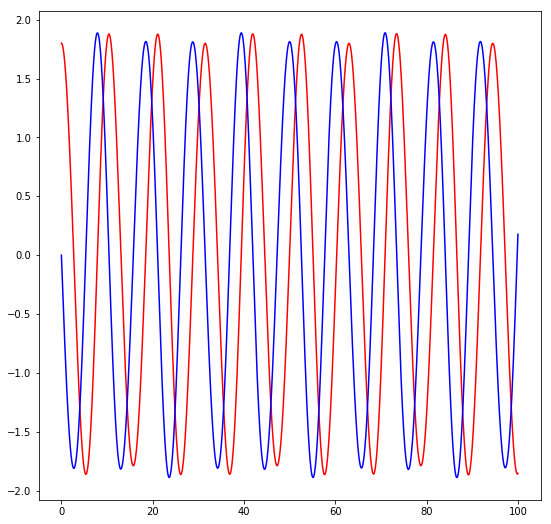

In [19]:
plt.rcParams["figure.figsize"] = (9, 9)
plt.plot(T, X, 'r');
plt.plot(T, Y, 'b');

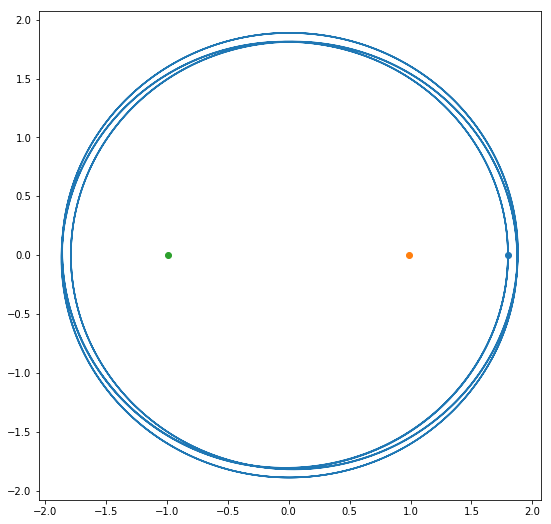

In [20]:
plt.plot(X, Y);
plt.scatter(x_0, y_0);
plt.scatter(1 - mu, 0);
plt.scatter(-mu_t, 0);

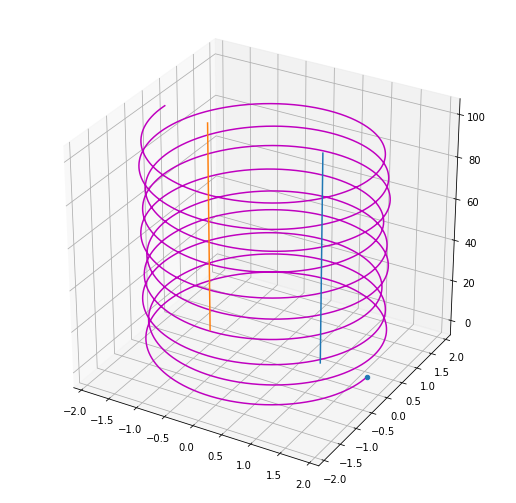

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X, Y, T, 'm');
ax.scatter(x_0, y_0, 0);
planet_1x = np.zeros(N_time)
planet_2x = np.zeros(N_time)
planet_1y = np.zeros(N_time)
planet_2y = np.zeros(N_time)
for i in range(N_time):
    planet_1x[i] = 1 - mu
    planet_2x[i] = -mu_t
ax.plot(planet_1x, planet_1y, T);
ax.plot(planet_2x, planet_2y, T);

In [11]:
p1 = periodic(time, h, A)
period(p1)

20048
40048
65656


1.0942666666666667

In [12]:
B = cros1(time, 2*h)

In [13]:
def pogrxperiod(R, periodic, h, time):
    counter = len(periodic) - 1
    pogr = np.zeros(counter)
    ind = np.zeros(counter)
    v = 1 / 2*h
    for i in range(counter):
        ind[i] = v * periodic[i+1]
        print(ind[i])
    for j in range(counter):
        pogr[j] = R[j]
    return pogr
    

In [14]:
R = runge(time, h, A, B)

In [15]:
max(R)

153.9886532716728

In [16]:
p2 = periodic(time, 2*h, B)
period(p2)

10001
20001
30002
40002
50747
869321


14.488683333333336

In [17]:
pogr1 = pogrxperiod(R, p1, h, time)

2.506e-05
5.0060000000000005e-05
8.207e-05


In [18]:
pogr1

array([0.00000000e+00, 8.13614731e-11, 2.04123940e-10])